In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'
# import functions from the modsim.py module
from modsim import *
import scipy.signal as sigw

# Question: How does the transient response of a full-wave bridge rectifier change given different waveforms? 

The purpose of a full-wave bridge rectifier is to take an AC input and turn it into a DC output.
A full-wave bridge rectifier consists of two parts: the full-wave rectifier, made by four diodes, and an RLC circuit to stabilize the output. Refer to Figure 1 for a diagram of the circuit we are simulating.
This rectifier design is one of many, but the task it accomplishes is all around us in devices wall adapters, chargers, and appliances.

Its prevalence in numerous appliances and technologies today implies its importance to both users and designers. For those designing circuits based around full wave rectifiers, the different stages of the recitifier's output, the transient and steady state stages, are the main points of interest. The transient stage, or the stage in which the voltage response of the rectifier is still stabilizing, is of particular interest, because it indicates both the stabiility and robustness of the rectifier design. It also points out at what time the transient response steadies to the equilibrium voltage output. Investigations into this usually require physical construction of rectifier prototypes, which can become costly over time, as well as demanding in manual effort.

In comparison, utilizing a model to understand these rectifier design responses is far more ideal. Doing so would allow quick sweeping of different design (bridge design) and control (input waveforms to the rectifier) parameters. We therefore approach the question by constructing a model that allows sweeping of different waveforms through the rectifier. The model will output the rectifier response, which we can use to understand the transient responses per different waveform.

The model is constructed via two different approaches, abstraction and analytical breakdown, and can be simulated using either. Validation of the model's results is done by comparing results against that of a commercial-grade modeling tool.

# System Setup

To initialize our system, we need to construct two key components: the input wave generator, and the actual rectifier system.

The input wave generator is essentially a function that outputs the input voltage over time; because we are interested in dealing with multiple types of input functions, we created a convenience wrapper function that returns the desired input function. Essentially, it acts as a input wave *function* generator; it takes inputs of wave type, frequency, RMS voltage amplitude, and phase shift to create and return us our desired input wave function.

In [2]:
def v_source_func(wave_type = "sine", frequency = 1, A_rms = 1, phi = 0):
    """
    Defines the source voltage function as a sinusoidal wave changing with respect to time
    Parameters:
        wave_type: Type of waveform profile desired for source voltage function
        frequency: Frequency of wave in Hz
        A_rms: RMS Amplitude of source voltage wave, in V
        phi: Phase shift for source voltage wave - only used for sine wave - in radians
    Returns:
        Source voltage function of general form A*wave(w*t), adhering to the provided parameters
    """
    
    def v_sine(t, omega = 2 * np.pi * frequency, A = A_rms * np.sqrt(2), phi = phi):
        """
        Return a sine wave with passed frequency (Hz) and amplitude (Volts)
        Parameters:
            t: Single value representing time, or array of time steps
            A: Amplitude of the sine wave, assumed equal to 1 V
            omega: Frequency of the sine wave, assumed equal to 1 Hz
            phi: Phase shift of the wave, assumed equal to 0
        Returns:
            The function of a standard sine wave A*sin(w*t+phi) with the given parameters
        """
        return A * np.sin(omega * t + phi)

    def v_square(t, omega = 2 * np.pi * frequency, A = A_rms * 1):
        """
        Return a square wave with passed frequency (Hz) and amplitude (Volts)
            t: Single value representing time, or array of time steps
            A: Amplitude of the square wave, assumed equal to 1 V
            omega: Frequency of the square wave, assumed equal to 1 Hz
        Returns:
            The function of a standard square wave A*square(w*t) with the given parameters
        """
        return A * sigw.square(omega * t)

    def v_sawtooth(t, omega = 2 * np.pi * frequency, A = A_rms * np.sqrt(3)):
        """
        Return a sawtooth wave with passed frequency (Hz) and amplitude (Volts)
            t: Single value representing time, or array of time steps
            A: Amplitude of the sawtooth wave, assumed equal to 1 V
            omega: Frequency of the sawtooth wave, assumed equal to 1 Hz
        Returns:
            The function of a standard sawtooth wave A*sawtooth(w*t) with the given parameters
        """
        return A * sigw.sawtooth(omega * t)

    def v_triangle(t, omega = 2 * np.pi * frequency, A = A_rms * np.sqrt(3)):
        """
        Return a triangle wave with passed frequency (Hz) and amplitude (Volts)
            t: Single value representing time, or array of time steps
            A: Amplitude of the triangle wave, assumed equal to 1 V
            omega: Frequency of the triangle wave, assumed equal to 1 Hz
        Returns:
            The function of a standard triangle wave A*triangle(w*t) with the given parameters
        """
        return A * sigw.sawtooth(omega * t,0.5)
    
    waveforms = {"sine":v_sine, "square":v_square, "sawtooth":v_sawtooth, "triangle":v_triangle}
    
    try:
        return waveforms[wave_type]
    except:
        print('Argument error. Specifiy either sine, square, triangle, or sawtooth.')

Here, we define our actual system: the State object, and the System parameters. The State object will contain the values of our states as they evolve over time, while the System parameters will contain key physical parameteric values, such as inductance, load resistance, capacitance, and the input voltage wave function. It will also contain information for the simulation, such as simulation start and end time.

Once again, we use a wrapper function to generate our system for us - it takes in four parameters:
 - The linearization method to be simulated, either abstract or analytical.
 - The simulation start and end times.
 - The input waveform type.

In [3]:
def make_system(linearization="abstract", t0=0, t_end=1, waveform="sine"):
    """
    Defines and returns a System object containing the system parameters
    Parameters:
        linearization: Specify what kind of linearization model will use, to define initial states
        t0: Start time of simulation
        t_end: End time of simulation
        waveform: Type of input voltage waveform
    Returns:
        init: Initial states of the model
            I: Current across bridge - 0 A
            V_C: Voltage across capacitor - 0 V at start
        v_s: Voltage Source Function with the following characteristics:
            Sine Function
            Amplitude of 120 V
            Frequency of 60 Hz
            Phase Shift of 0 radians
        R: Load resistance of the RLC bridge
        L: Inductance of the RLC bridge
        C: Capacitance of the RLC bridge
    """
    
    if linearization == "abstract":
        init = State(I = 0, V_C = 0)
    else:
        init = State(Vout=0,dVoutdt=0)
    
    return System(init=init, t0 = t0, t_end = t_end, 
                  v_s = v_source_func(wave_type = waveform, frequency = 60, A_rms = 120, phi = 0), 
                  L = 1, R = 1, C = 1)

# Linearization

Full wave rectifiers consist of a system of diodes that work to force the output current and voltage to remain positive; essentially, the rectification applies an absolute value function to the input current and voltage. As this doesn't stabilize the output voltage to a constant value, the bridge is added. The bridge design we are considering, an RLC circuit as seen in Figure 1, 

## Via Abstraction

In [4]:
def slope_func_abstract(state, t, system):
    """
    Calculates and returns the differential changes of states at any point in time
    Parameters:
        state: State object containing values of states at time t
        t: Time of simulation
        system: System object containing system parameters
    Returns:
        dIdt: Differential change in current at time t
        dVcdt: Differential change in voltage across capacitor at time t
    """
    
    # Extract state values
    I, V_C = state
    
    # Rectify incoming voltage
    rectified_V_source = np.abs(system.v_s(t))
    
    # Define current flowing through load
    i_load = V_C / system.R
    
    # Define voltage across the inductor
    V_inductor = rectified_V_source - V_C
    
    # Determine differential change in current
    if V_inductor > 0:
        dIdt = V_inductor / system.L
    else:
        dIdt = -V_C/system.L
    if I < 0 and dIdt < 0:
        # Limit current to remain positive (following restriction placed by diode arrangement)
        dIdt = 0
    
    # Define differential change in voltage across capacitor (voltage used by load)
    dVcdt = (I - i_load) / system.C
    
    return dIdt, dVcdt

## Via Analytical Breakdown

In [5]:
def slope_func_analytic(state, t, system):
    """Calculate the slopes.
    
    state: State (Vout, dVoutdt)
    t: time
    system: System object
    
    returns: State (dVoutdt, d2Voutdt2)
    """
    
    #Get local variables
    Vout, dVoutdt = state
    
    #Calculate slopes according to our equations
    d2Voutdt2 = 1/(system.L*system.C) * (abs(system.v_s(t)) - (system.L/system.R)*dVoutdt - Vout)
    dVoutdt = (system.R/system.L) * (abs(system.v_s(t)) - (system.L*system.C)*d2Voutdt2 - Vout)
    
    return dVoutdt, d2Voutdt2

## Combine different linearizations

In [6]:
def slope_function(linearization):
    """
    Chooses which slope function to use, depending on style of linearization to use
    Parameter:
        linearization: either 'abstract' or 'analytic', decides which slope function to use
    Returns:
        Appropriate slope function, as specified by the input parameter
    """
    
    if linearization == "abstract":
        return slope_func_abstract
    else:
        return slope_func_analytic

# Model Simulation

In [7]:
def run_simulation(input_waveforms, linearization):
    """
    Runs simulation of Full Wave RLC Bridge Rectifier response for each input waveform type and given linearization type.
    Parameters:
        input_waveforms: List of desired waveform types
        linearization: Type of linearization desired for model (abstraction or analytical)
    Returns:
        DataFrame object containing results from simulation:
            Index: waveform types
            Columns: 'results' and 'details'
            Simulation results type: TimeFrame object, style following that returned by modsim.run_ode_solver
    """
    
    # Create slope function
    slope_func = slope_function(linearization)
    
    # Define output DataFrame object
    output = pd.DataFrame(index = input_waveforms, columns = ['results', 'details'])
    
    # Create convenience variable for properly labeling the output
    iw_label_no = pd.Series(np.linspace(0, len(input_waveforms)-1, len(input_waveforms), dtype = int),
                            index = input_waveforms)
    
    for i in input_waveforms:
        # Make the system
        system = make_system(linearization,0,15,i)

        # Run the simulation and display the time taken and success
        output.iloc[iw_label_no[i]] = run_ode_solver(system,slope_func,max_step=1e-4);
    return output

In [8]:
def plot_results(results):
    """
    Plot results provided. Assumes that there only two state variables in model system.
    Parameter:
        results: Simulation results. Follows type returned by run_simulation
    Returns:
        None
    Plots:
        Two graphs, for each state. Plots results from each waveform run on same graph per state.
    """
    
    # Extract results data from input
    to_plot = results['results']
    
    # Plot data
    for res in to_plot:
        plt.figure(1)
        res[res.columns[0]].plot()
        
        plt.figure(2)
        res[res.columns[1]].plot()
        
    # Extract name of first and second states
    first_state_name = to_plot[to_plot.index[0]].columns[0]
    second_state_name = to_plot[to_plot.index[0]].columns[1]
    
    # Label graph of first state
    plt.figure(1)
    plt.title("Comparison of " + first_state_name + "'s transient response over time")
    plt.ylabel(first_state_name)
    plt.xlabel('Time (s)')
    plt.legend(results.index)
    
    # Label graph of second state
    plt.figure(2)
    plt.title("Comparison of " + second_state_name + "'s transient response over time")
    plt.ylabel(second_state_name)
    plt.xlabel('Time (s)')
    plt.legend(results.index)

In [9]:
input_waveforms = ["sine", "square", "sawtooth", "triangle"]
responses = run_simulation(input_waveforms, linearization="abstract")

,results,details
sine,I V_C 0.0000 0.0...,sol ...
square,I V_C 0.0000 0...,sol ...
sawtooth,I V_C 0.0000 0.0...,sol ...
triangle,I V_C 0.0000 0.0...,sol ...


# Results

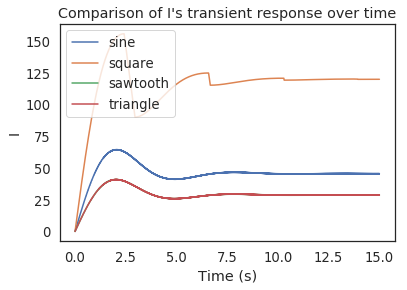

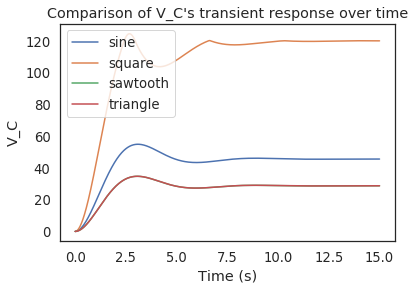

In [10]:
plot_results(responses)

# Validation against FMU Simulation

In [19]:
fmu_sine_Vout = pd.read_csv('FMUSimSineWaveData_Vout.csv')

,0.0,0.0.1
0,7.621146e-18,0.000000e+00
1,7.621146e-18,0.000000e+00
2,4.701580e-07,3.324517e-15
3,9.403160e-07,1.329807e-14
4,2.223347e-06,1.035538e-13
5,3.506378e-06,3.178981e-13
6,4.789408e-06,7.200545e-13
7,6.072439e-06,1.375750e-12
8,8.655291e-06,3.828062e-12
9,1.328267e-05,1.373373e-11


In [21]:
fmu_sine_Vout = pd.Series(fmu_sine_Vout['0.0.1'].values, index=fmu_sine_Vout['0.0'].values)

7.621146e-18    0.000000e+00
7.621146e-18    0.000000e+00
4.701580e-07    3.324517e-15
9.403160e-07    1.329807e-14
2.223347e-06    1.035538e-13
3.506378e-06    3.178981e-13
4.789408e-06    7.200545e-13
6.072439e-06    1.375750e-12
8.655291e-06    3.828062e-12
1.328267e-05    1.373373e-11
2.141025e-05    5.793657e-11
3.560517e-05    2.689916e-10
6.097696e-05    1.364790e-09
1.299208e-04    1.411964e-08
1.589416e-04    2.419928e-08
1.879624e-04    3.848625e-08
2.169832e-04    5.780818e-08
2.460040e-04    8.296029e-08
2.750248e-04    1.147265e-07
3.040455e-04    1.538864e-07
3.330663e-04    2.012174e-07
3.620871e-04    2.574957e-07
3.911079e-04    3.234961e-07
4.201287e-04    3.999923e-07
4.491495e-04    4.877566e-07
4.781702e-04    5.875600e-07
5.071910e-04    7.001720e-07
5.362118e-04    8.263605e-07
5.652326e-04    9.668919e-07
5.942534e-04    1.122531e-06
                    ...     
9.991926e+00    5.409136e+01
9.992020e+00    5.409139e+01
9.992115e+00    5.409141e+01
9.992318e+00  

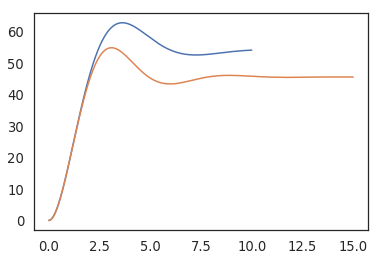

In [23]:
fmu_sine_Vout.plot()
responses['results']['sine']['V_C'].plot()